### Plot the prediction results

In [ ]:
item = 'non_grid_5000' # item name in config.yml

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torchinfo import summary
import scipy.io as scio
import sys
from matplotlib.collections import LineCollection

from timeit import default_timer
sys.path.append("..") 
from run.conv_TE import *

II = complex(0,1)
cm = 1/2.54

In [3]:
def get_k(file_name):

    data = scio.loadmat(file_name)
    zn0 = data['zn0'][0] 
    yn0 = data['yn0'][0]
    sig_k = data['sig_k']
    return zn0,yn0,sig_k

def get_TE_loader(train_file,test_file,n_train,n_test,batch_size,f_idx):
    np_dtype = np.float32
    nza,zn, yn, freq0_train, ry, sig0,response0= get_data(train_file)

    t_flatten = torch.nn.Flatten(0,1)
    dy = yn[1:] - yn[:-1]
    dz = zn[1:] - zn[:-1]
    # n_beta = n_train * f_idx[1]

    freq_train0 = (freq0_train[::f_idx[0]][-f_idx[1]:]).reshape(-1,1,1)
    sig = sig0[:n_train]
    response = response0[:n_train,::f_idx[0],...][:,-f_idx[1]:,...]

    sigc = sig_add(sig)
    m,ny = np.shape(sigc)[-2:]
    imsize = m
    # sig     = torch.from_numpy(sig.astype(np_dtype))
    sigc_train = torch.repeat_interleave(torch.from_numpy(sigc.astype(np_dtype)),f_idx[1],dim=0)
    freq_train = torch.from_numpy(freq_train0.astype(np_dtype)).repeat(n_train,1,1)
    # result

    x_train = sigc_train*freq_train
    x_train = x_train.unsqueeze(-1)

    u_bc_train = np.zeros((f_idx[1],imsize),dtype=np.complex64)
    for ii in range(f_idx[1]):
        u_bc_train[ii,:] = mt1dte(freq_train0[ii,0,0],dz,sig[0,:,0])    
    u_bc_train = torch.from_numpy(u_bc_train.astype(np.complex64)).repeat(n_train,1)

    y_train = t_flatten(torch.from_numpy(response.astype(np_dtype))) # remove value on the boundary
    train_data = torch.utils.data.TensorDataset(x_train, y_train,u_bc_train)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True,drop_last=True) 

    _,_,_,freq0_test, ry, sig0,response0= get_data(test_file)
    freq_test0     = (freq0_test[::f_idx[2]][-f_idx[3]:]).reshape(-1,1,1)
    sig      = sig0[:n_test]
    response = response0[:n_test,::f_idx[2],...][:,-f_idx[3]:,...]
    sigc = sig_add(sig)
    # sig = torch.from_numpy(sig0[:n_test].astype(np_dtype))
    # x_test = torch.from_numpy(np.expand_dims(sig,-1).astype(np_dtype))
    sigc_test = torch.repeat_interleave(torch.from_numpy(sigc.astype(np_dtype)),f_idx[3],dim=0)
    sig_test  = torch.repeat_interleave(torch.from_numpy(sig.astype(np_dtype)),f_idx[3],dim=0)
    freq_test = torch.from_numpy(freq_test0.astype(np_dtype)).repeat(n_test,1,1)
    x_test = sigc_test*freq_test
    x_test = x_test.unsqueeze(-1)

    u_bc_test = np.zeros((f_idx[3],imsize),dtype=np.complex64)
    for ii in range(f_idx[3]):
        u_bc_test[ii,:] = mt1dte(freq_test0[ii,0,0],dz,sig[0,:,0])
    u_bc_test  = torch.from_numpy(u_bc_test.astype(np.complex64)).repeat(n_test ,1)

    y_test = t_flatten(torch.from_numpy(response.astype(np_dtype)))
    test_data = torch.utils.data.TensorDataset(x_test,y_test,sig_test,freq_test,u_bc_test)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size*f_idx[3], shuffle=False) 

    x_normalizer = Normalizer(x_train)
    y_normalizer = Normalizer_out(u_bc_train)
    # BC
    ry      = ry.astype(np_dtype)
    yn      = yn.astype(np_dtype)
    zn      = zn.astype(np_dtype)   
    dy = torch.from_numpy(dy.astype(np_dtype))
    dz = torch.from_numpy(dz.astype(np_dtype))
    return nza,zn,yn,dz,dy,ry,train_loader,test_loader, x_normalizer,y_normalizer
def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

In [4]:
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['axes.titlesize'] = 8
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

cm = 1/2.54

In [5]:
with open( '../run/config.yml') as f:
    config = yaml.full_load(f)
config = config[item]
cuda_id = "cuda:"+str(config['cuda_id'])
device = torch.device(cuda_id if torch.cuda.is_available() else "cpu")
train_file = config['TRAIN_PATH']
test_file  = config['TEST_PATH']
f_idx       = config['f_idx']
modes   = config['modes']
# modes2   = config['modes2']
width    = config['width']     
layer_num= config['layer_num']
last_size= config['last_size']
act_fno  = config['act_fno']
init_func = config['init_func']
n_train   = config['n_train']
n_test    = config['n_test']
batch_size = config['batch_size']
save_mode  = config['save_mode']
save_step  = config['save_step']
model_path = "../model/TE_"+item # save path and name of model
model_path_temp = "../temp/"+item
log_path = "../Log/TE_"+item+'.log'
tf_epochs = config['tf_epochs']
tf_lr     = config['tf_lr']
weight_decay = config['weight_decay']
step_size = config['step_size']
gamma = config['gamma']
patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

n_out=2
# device = "cpu"

####################
begin to train model


In [6]:

nza,zn,yn,dz,dy,ry0,train_loader,TE_test_loader, TE_x_normalizer,y_normalizer\
             = get_TE_loader(train_file,test_file,n_train,n_test,batch_size,f_idx)
zn0,yn0,sig_k = get_k(test_file)

In [7]:
if os.path.exists(model_path+'.pkl'):
    TE_model=FNO2d(modes, modes, width, n_out, layer_num, last_size, act_fno,init_func).to(device)
    TE_model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
    
else:
    raise RuntimeError('no model file')
# model=torch.load('../model/base.pt',map_location=device)

init_func: xavier_uniform
init_func: xavier_uniform
init_func: xavier_uniform
init_func: xavier_uniform


In [8]:
loss_func = LpLoss_out2(axis=(1,2),size_average=False)

n_freq_test = f_idx[3]

t1 = default_timer()

TE_model.train()
test_l2 = 0.0
n_ry = len(ry0)
with torch.no_grad():
    for x, y ,sig,freq,u_bc in TE_test_loader:
        n_batch = x.shape[0]
        n_samples = n_batch//f_idx[3]
        x, y,sig,freq,u_bc = x.to(device), y.cpu().numpy(), sig.cpu().numpy(),freq.cpu().numpy(),u_bc.to(device)
        out = TE_model(TE_x_normalizer.encode(x))
        # out = model(x)
        # out = self.y_normalizer.decode(out)
        impose_bc(out,u_bc)
        rhoxy, phsxy = get_response(out.cpu().numpy(),sig,dy.cpu().numpy(),\
            dz.numpy(),ry0,yn,nza,freq)

        rhoxy = np.log10(rhoxy.reshape(n_samples,f_idx[3],n_ry))
        phsxy = phsxy.reshape(n_samples,f_idx[3],n_ry)
        rho_real = np.log10(y[...,0].reshape(n_samples,f_idx[3],n_ry))
        phs_real = y[...,1].reshape(n_samples,f_idx[3],n_ry)
        xy_pred = np.stack([rhoxy,phsxy],axis=-1)
        xy_true = np.stack([rho_real,phs_real],axis=-1)
        loss = loss_func(xy_pred,xy_true)
        test_l2 += loss
                
test_l2 = test_l2/n_test                
t2 = default_timer()
print(t2-t1, np.sum(test_l2)/(2))
print(test_l2)

12.341219871072099 0.010821456089615822
[0.00686812 0.01477479]


In [9]:
from run.conv_TM_TFM import *

def get_TM_loader(train_file,test_file,n_train,n_test,batch_size,f_idx):
    np_dtype = np.float32
    nza,zn, yn, freq0_train, ry, sig0,response0= get_data(train_file)
    zn = zn[nza:]

    t_flatten = torch.nn.Flatten(0,1)
    dy = yn[1:] - yn[:-1]
    dz = zn[1:] - zn[:-1]
    # n_beta = n_train * f_idx[1]

    freq_train0 = (freq0_train[::f_idx[0]][-f_idx[1]:]).reshape(-1,1,1)
    sig = sig0[:n_train]
    response = response0[:n_train,::f_idx[0],...][:,-f_idx[1]:,...]

    sig = sig_add(sig,nza)
    m,ny = np.shape(sig)[-2:]
    imsize = m
    # sig     = torch.from_numpy(sig.astype(np_dtype))
    sig_train= torch.repeat_interleave(torch.from_numpy(sig.astype(np_dtype)),f_idx[1],dim=0)
    freq_train = torch.from_numpy(freq_train0.astype(np_dtype)).repeat(n_train,1,1)
    # result
    # [sig0*f0,...]
    # [sig0*f1,...]
    x_train = sig_train*freq_train
    x_train = x_train.unsqueeze(-1)

    u_bc_train = np.zeros((f_idx[1],imsize),dtype=np.complex64)
    ey1d = np.zeros((f_idx[1],imsize),dtype=np.complex64)
    for ii in range(f_idx[1]):
        ey1d[ii,:],u_bc_train[ii,:] = mt1dtm(freq_train0[ii,0,0],dz,sig[0,:-1,0])    
    u_bc_train = torch.from_numpy(u_bc_train.astype(np.complex64)).repeat(n_train,1)
    ey1d = torch.from_numpy(ey1d.astype(np.complex64)).repeat(n_train,1)


    y_train = t_flatten(torch.from_numpy(response.astype(np_dtype))) # remove value on the boundary
    train_data = torch.utils.data.TensorDataset(x_train, y_train,u_bc_train,ey1d)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True,drop_last=True) 

    _,_,_,freq0_test, ry, sig0,response0= get_data(test_file)
    freq_test0     = (freq0_test[::f_idx[2]][-f_idx[3]:]).reshape(-1,1,1)
    sig      = sig0[:n_test]
    response = response0[:n_test,::f_idx[2],...][:,-f_idx[3]:,...]
    sig = sig_add(sig,nza)
    # sig = torch.from_numpy(sig0[:n_test].astype(np_dtype))
    # x_test = torch.from_numpy(np.expand_dims(sig,-1).astype(np_dtype))
    sig_test = torch.repeat_interleave(torch.from_numpy(sig.astype(np_dtype)),f_idx[3],dim=0)
    freq_test = torch.from_numpy(freq_test0.astype(np_dtype)).repeat(n_test,1,1)
    x_test = sig_test*freq_test
    x_test = x_test.unsqueeze(-1)

    u_bc_test = np.zeros((f_idx[3],imsize),dtype=np.complex64)
    for ii in range(f_idx[3]):
        _,u_bc_test[ii,:] = mt1dtm(freq_test0[ii,0,0],dz,sig[0,:-1,0])
    u_bc_test  = torch.from_numpy(u_bc_test.astype(np.complex64)).repeat(n_test ,1)

    y_test = t_flatten(torch.from_numpy(response.astype(np_dtype)))
    test_data = torch.utils.data.TensorDataset(x_test,y_test,sig_test,freq_test,u_bc_test)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size*f_idx[3], shuffle=False) 

    x_normalizer = Normalizer(x_train)
    y_normalizer = Normalizer_out(u_bc_train)
    # BC
    ry      = ry.astype(np_dtype)
    yn      = yn.astype(np_dtype)
    zn      = zn.astype(np_dtype)   
    dy = torch.from_numpy(dy.astype(np_dtype))
    dz = torch.from_numpy(dz.astype(np_dtype))


    return zn,yn,dz,dy,ry,train_loader,test_loader, x_normalizer,y_normalizer

In [10]:
zn,yn,dz,dy,ry0,train_loader,TM_test_loader,TM_x_normalizer,y_normalizer\
             = get_TM_loader(train_file,test_file,n_train,n_test,batch_size,f_idx)

model_TM_path = "../model/TM_"+item
if os.path.exists(model_TM_path+'.pkl'):    
    TM_model=FNO2d(modes, modes, width, n_out, layer_num, last_size, act_fno,init_func).to(device)
    TM_model.load_state_dict(torch.load(model_TM_path+'.pkl',map_location=device))
    
else:
    raise RuntimeError('no model file')
# model=torch.load('../model/base.pt',map_location=device)

init_func: xavier_uniform
init_func: xavier_uniform
init_func: xavier_uniform
init_func: xavier_uniform


In [11]:


t1 = default_timer()

TM_model.train()
test_l2 = 0.0
n_ry = len(ry0)
with torch.no_grad():
    for x, y,sig,freq0,u_bc in TM_test_loader:
        n_batch = x.shape[0]
        n_samples = n_batch//f_idx[3]
        x, y,sig,freq0,u_bc = x.to(device), y.numpy(),sig.numpy(),freq0.numpy(),u_bc.to(device)
        out = TM_model(TM_x_normalizer.encode(x))
        # out = self.y_normalizer.decode(out)
        impose_bc(out,u_bc)
        rhoyx, phsyx = get_response(out.detach().cpu().numpy(),sig[:,:-1,:-1],\
            dy.numpy(),dz.numpy(),ry0,yn,freq0)
        
        rhoyx = np.log10(rhoyx.reshape(n_samples,f_idx[3],n_ry))
        phsyx = phsyx.reshape(n_samples,f_idx[3],n_ry)
        rho_real = np.log10(y[...,2].reshape(n_samples,f_idx[3],n_ry))
        phs_real = y[...,3].reshape(n_samples,f_idx[3],n_ry)
        yx_pred = np.stack([rhoyx,phsyx],axis=-1)
        yx_true = np.stack([rho_real,phs_real],axis=-1)
        
        loss = loss_func(yx_pred,yx_true)
        test_l2 += loss
        
test_l2 = test_l2/n_test                
t2 = default_timer()
print(t2-t1, np.sum(test_l2)/(2))
print(test_l2)

MT_pred = np.concatenate((xy_pred,yx_pred),axis=-1)
MT_true = np.concatenate((xy_true,yx_true),axis=-1)

10.129948308924213 0.02654668797695662
[0.03284603 0.02024735]


In [12]:
n_z,n_y = sig.shape[-2:]
sig0 = sig.reshape(n_samples,f_idx[3],n_z,n_y)

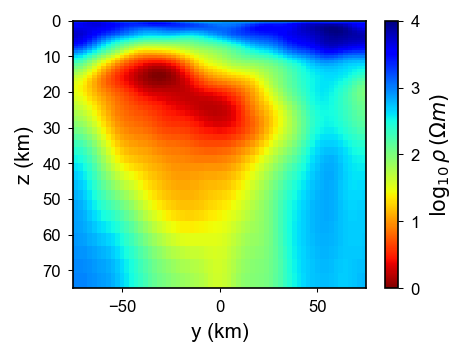

Relative rhoxy,rhoyx, phsxy,phsyx error:  0.002832799169100375 0.005881648867858729 0.010906938375622602 0.01901132946166572


In [13]:
cm = 1/2.54
rho_id = 4 # 11,31,13,22 is better
ry  = ry0
freq=freq0[:f_idx[3]].flatten()
a_cof = np.log10(1/sig0[rho_id,0,:-11,10:-11])
n_bins = 5 # number of ticks in colorbar

fig = plt.figure(figsize=(8*cm,6*cm),dpi=150)
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn0/1e3,zn0/1e3,a_cof, vmin=0,vmax=4,
                shading='flat',cmap='jet_r')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\log_{10}\,\rho\,(\Omega m)$")# ax = plt.subplot(3,2,2)
cbar.ax.locator_params(nbins=n_bins)

# plt.savefig("../imags/block_resisitivety_r"+str(rho_id)+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

# rhoxy = MT_pred[rho_id, ...,0]
rhoxy = MT_pred[rho_id, ...,0]
rhoyx = MT_pred[rho_id, ...,2]
phsxy = -1*MT_pred[rho_id, ...,1]
phsyx = -1*MT_pred[rho_id, ...,3]+180

rhoxy_true = MT_true[rho_id, ...,0]
rhoyx_true = MT_true[rho_id, ...,2]
phsxy_true = -1*MT_true[rho_id, ...,1]
phsyx_true = -1*MT_true[rho_id, ...,3]+180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
    error_r(rhoxy,rhoxy_true),error_r(phsxy,phsxy_true),error_r(rhoyx,rhoyx_true),error_r(phsyx,phsyx_true),)

In [14]:
a_cof.shape

(63, 63)

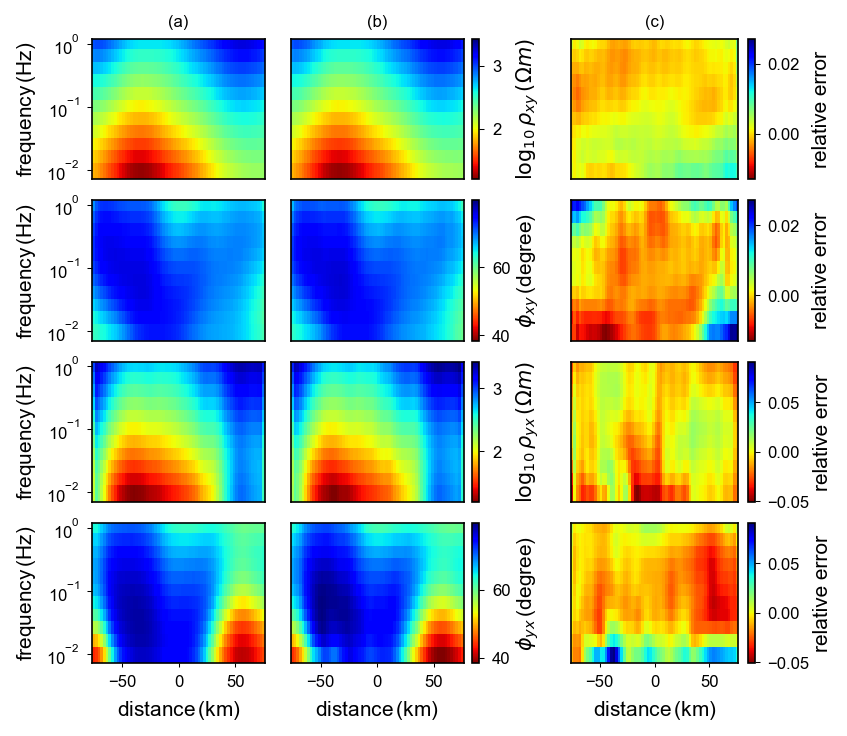

In [18]:
obs_id = 35# idx of frequency
f_id = 40# idx of frequency
id_f = 40
n_row,n_column = 4,3
figsize   = (5*n_column*cm,3.5*n_row*cm)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 10 # text size
bar_size       = 10 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 8# font size of the axes title
title_out = ['(a)','(b)','(c)']
# title_out = ['FD','transfer','relative error']

bar_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',r'$\phi_{xy}\,$(degree)',\
             r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'
rhoxy_error = rhoxy_true-rhoxy
phsxy_error = phsxy_true-phsxy
rhoyx_error = rhoyx_true-rhoyx
phsyx_error = phsyx_true-phsyx
data = [[rhoxy_true,rhoxy,],
        [phsxy_true,phsxy,],
        [rhoyx_true,rhoyx,],
        [phsyx_true,phsyx,]
        ]
data_error=[[rhoxy_error/rhoxy_true],
            [phsxy_error/phsxy_true],
            [rhoyx_error/rhoyx_true],
            [phsyx_error/phsyx_true]]

norm_rhoxy = colors.Normalize(vmin=np.min(np.concatenate([data[0],data[2]])),vmax=np.max(np.concatenate([data[0],data[2]])))
norm_phsxy = colors.Normalize(vmin=np.min(np.concatenate([data[1],data[3]])),vmax=np.max(np.concatenate([data[1],data[3]])))
norm_rhoyx = colors.Normalize(vmin=np.min(np.concatenate([data[2],data[0]])),vmax=np.max(np.concatenate([data[2],data[0]])))
norm_phsyx = colors.Normalize(vmin=np.min(np.concatenate([data[3],data[1]])),vmax=np.max(np.concatenate([data[3],data[1]])))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
norm_error1 = colors.Normalize(vmin=np.min(np.concatenate(data_error[:2]))
                              ,vmax=np.max(np.concatenate(data_error[:2])))
norm_error2 = colors.Normalize(vmin=np.min(np.concatenate(data_error[2:]))
                              ,vmax=np.max(np.concatenate(data_error[2:])))
norm_error = [norm_error1,norm_error1,norm_error2,norm_error2]

labelpad        = [6,2,6,2] # label pad between label and bar (value is relative to axis value?)  
labelpad_error  = [6,6,2,2] #label pad between label and bar (value is relative to axis value?) 
pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)#,constrained_layout = True)
h= ax.copy()
for j in range(n_column):
    for i in range(n_row):
        if j!=n_column-1:
            h[i,j] = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
#             ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#             ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        else: 
            h[i,j] = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading,norm=norm_error[i])

#             if i!=4:
#                 h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading)
#             else:
#                 h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0],norm=norm_error4, shading=shading)
                
            
        ax[i,j].set_yscale("log")
        ax[i,j].set_xticks([-50,0,50])
        ax[i,j].minorticks_off()
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0 :
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        elif j==1 or j==2 :
            ax[i,j].set_yticks([])
        

#             cbar.formatter.set_powerlimits((0, 0))
            
            
    ax[i,j].set_xlabel(x_label)
#         if j!=0 or i!=0:
#             ax[i,j].set_xticks([])
#             ax[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.15,hspace=0.15)
for j in range(n_column):
    for i in range(n_row):
        if j == n_column-2:
            cbar = fig.colorbar(h[i,j],ax=[ax[i,jj] for jj in range(n_column-1)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        elif j==n_column-1:
            cbar = fig.colorbar(h[i,j],ax=ax[i,j] ,location=loc,pad=pad+0.025)
#             cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.set_label('relative error',fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
# plt.savefig("../imags/non_grid_compare.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/non_grid_compare.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()